set directory

In [1]:
import os
Task_name = 'Assignment1&2 dataset'
data_root = "/home/p88101029/"
raw_data_base = os.path.join(data_root,Task_name)
os.makedirs(raw_data_base, exist_ok=True)

In [21]:
listoffolder=sorted(os.listdir(raw_data_base), reverse=False)

open and save image

In [22]:
import cv2
import numpy as np
from numpy import asarray
images = []
imagescat = []
imagesnames = []
for folder in listoffolder:
    images_path = os.path.join(raw_data_base,folder)
    address = sorted(os.listdir(images_path))
    for imgadd in address:
        imagescat.append(folder)
        imagesnames.append(imgadd)
        img=cv2.imread(os.path.join(images_path,imgadd))
        images.append(asarray(img))


transform image to HOG features

In [23]:
winSize=(64,64)
blockSize=(16,16)
blockStride=(8,8)
cellSize=(8,8)
nbins=9
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)

In [24]:
padding=(0,0)
winStride=(8, 8)
imginhog=[]
for i in images:
    img=hog.compute(cv2.resize(i,(64,64)), winStride=winStride, padding=padding)
    imginhog.append(img)

In [25]:
imginhogarr=np.asarray(imginhog).reshape(64225, np.asarray(imginhog).shape[1])
imagescatarr=np.asarray(imagescat)

save / load features dataset

In [47]:
np.save('imginhogarr', imginhogarr)
np.save('imagescatarr', imagescatarr)

In [2]:
import cv2
import numpy as np
from numpy import asarray
imginhogarr=np.load('imginhogarr.npy')
imagescatarr=np.load('imagescatarr.npy')

split dataset into train/valid/test

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
X_trainvalid, X_test, y_trainvalid, y_test = train_test_split(imginhogarr,imagescatarr, test_size=0.1, random_state=0)

split_index = np.concatenate((np.ones(round(len(y_trainvalid)*0.8))*-1, np.zeros(round(len(y_trainvalid)*0.2))), axis=None)
pds = PredefinedSplit(test_fold = split_index)


In [101]:
train_index=()
test_index=()
for i, (train_index, test_index) in enumerate(pds.split()):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    train_index=train_index
    test_index=test_index

Fold 0:
  Train: index=[    0     1     2 ... 46239 46240 46241]
  Test:  index=[46242 46243 46244 ... 57799 57800 57801]


develop XGB model

In [6]:
from xgboost import XGBClassifier
xgb = XGBClassifier(objective="multi:softmax",eval_metric='mlogloss')

In [12]:
#fit model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
clf = GridSearchCV(estimator=xgb,cv=pds,scoring='accuracy',param_grid= {'max_depth': [4, 6, 8, 10]},return_train_score=True)
clf.fit(X_trainvalid, y_trainvalid)

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder i

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softmax',
                                     ran

check performance

In [13]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_max_depth',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [71]:
# top 1 validation accuracy
clf.cv_results_['split0_test_score']

array([0.11842561, 0.10968858, 0.1067474 , 0.10406574])

In [72]:
# top 1 training accuracy
clf.cv_results_['split0_train_score']

array([0.95761429, 0.99671294, 0.99671294, 0.99671294])

plot learning curve

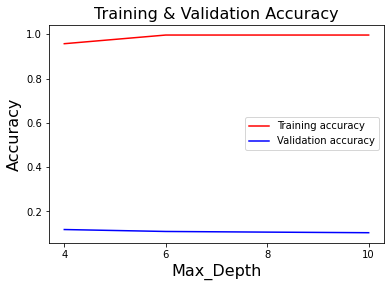

In [34]:
import matplotlib.pyplot as plt
 
Max_Depth = np.asarray([4, 6, 8, 10])

plt.plot(Max_Depth, clf.cv_results_['mean_train_score'], 'r', label='Training accuracy')
plt.plot(Max_Depth, clf.cv_results_['mean_test_score'], 'b', label='Validation accuracy')
plt.title('Training & Validation Accuracy', fontsize=16)
plt.xlabel('Max_Depth', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(np.arange(4,11,2))
plt.legend()

testing performance

In [94]:
# top 1 test accuracy
np.mean(clf.predict(X_test)==y_test)

0.12346255643780166

In [95]:
maxfive=np.argsort(clf.best_estimator_.predict_proba(X_test))[:,-5:]
maxfive

array([[22, 18, 15, 13, 14],
       [15, 18, 43, 22, 42],
       [13, 17, 39, 41, 20],
       ...,
       [36, 11, 40, 25,  9],
       [30, 36, 19, 16, 49],
       [30, 11, 39, 49,  3]])

In [96]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(imagescatarr)

LabelEncoder()

In [98]:
actual = encoder.transform(y_test).reshape(-1,1)
actual

array([[42],
       [24],
       [40],
       ...,
       [40],
       [13],
       [ 5]])

In [99]:
# top 5 test accuracy
np.mean((actual==maxfive).sum(-1))

0.3688307644402927

Since GridSearchCV defaulted refit=True, using the previous model to calculate top5 accuracy for validation set would have data leaked,
we have to train it again

In [104]:
xgb = XGBClassifier(objective="multi:softmax",eval_metric='mlogloss',max_depth=4)

In [105]:
xgb.fit(X_trainvalid[train_index],y_trainvalid[train_index])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=64,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [110]:
# top 1 validation accuracy
np.mean(xgb.predict(X_trainvalid[test_index])==y_trainvalid[test_index])

0.11842560553633218

In [114]:
maxfive=np.argsort(xgb.predict_proba(X_trainvalid[test_index]), axis=1)[:,-5:]
maxfive

array([[32,  9, 45, 36,  8],
       [29, 28,  8, 26,  7],
       [19, 31, 22, 30, 17],
       ...,
       [19, 46, 32, 37, 44],
       [27, 39, 23, 11,  2],
       [11, 43, 23,  1, 14]])

In [118]:
actual=encoder.transform(y_trainvalid[test_index]).reshape(-1,1)
actual

array([[ 7],
       [ 0],
       [14],
       ...,
       [33],
       [34],
       [ 2]])

In [119]:
# top 5 validation accuracy
np.mean((actual==maxfive).sum(-1))

0.3546712802768166